# Camera estimation

In [3]:
import cv2
import numpy as np
import supervision as sv
from ultralytics import YOLO


In [4]:
SOURCE_VIDEO_PATH="../data/test.mp4"

KEYPOINTS_DETECTION_MODEL_PATH = "../models/keypoints_detection.pt"
KEYPOINTS_DETECTION_MODEL = YOLO(KEYPOINTS_DETECTION_MODEL_PATH)

PLAYER_INFERENCE_MODEL_PATH = "../models/player_inference.pt"
PLAYER_INFERENCE_MODEL = YOLO(PLAYER_INFERENCE_MODEL_PATH)

BALL_INFERENCE_MODEL_PATH = "../models/ball_inference.pt"
BALL_INFERENCE_MODEL = YOLO(BALL_INFERENCE_MODEL_PATH)



0: 640x640 1 pitch, 717.9ms
Speed: 2.1ms preprocess, 717.9ms inference, 5.6ms postprocess per image at shape (1, 3, 640, 640)


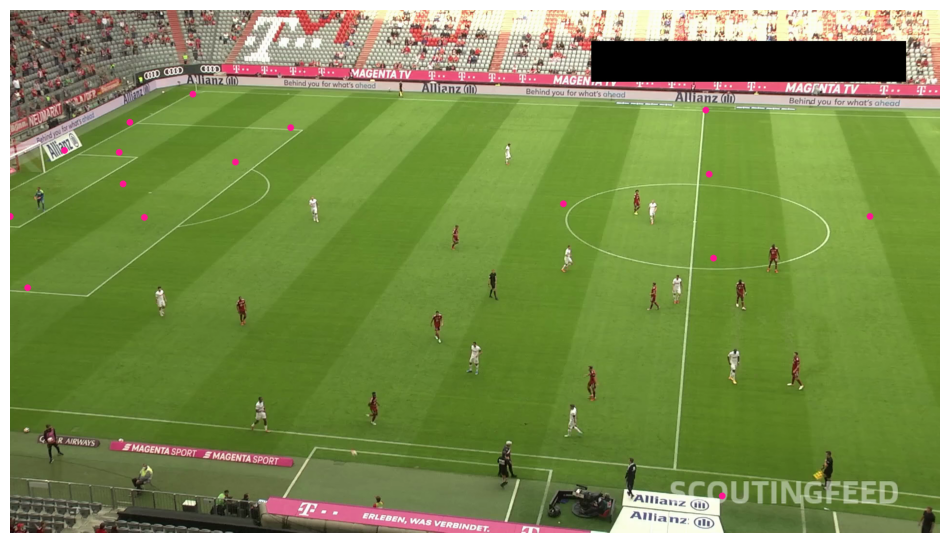

In [5]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex("#FF1493"),
    radius=7
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
height, width, _ = frame.shape
frame_image_resized = cv2.resize(frame, (640, 640))

result = KEYPOINTS_DETECTION_MODEL.predict(frame_image_resized, conf=0.3)[0]
keypoints = sv.KeyPoints.from_ultralytics(result)
keypoints.xy[0] = keypoints.xy[0] / 640 * np.array([width, height]).T

filter = keypoints.confidence[0] > 0.5
frame_reference_points = keypoints.xy[0][filter]
frame_reference_keypoints = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_keypoints)

sv.plot_image(annotated_frame)

### Project pitch lines on frame

In [6]:
from football_analytics.football_pitch.draw_football_pitch import (
    draw_football_pitch,
    draw_points_on_pitch,
)
from football_analytics.football_pitch.football_pitch_configuration import (
    FootballPitchConfiguration,
)

CONFIG = FootballPitchConfiguration()

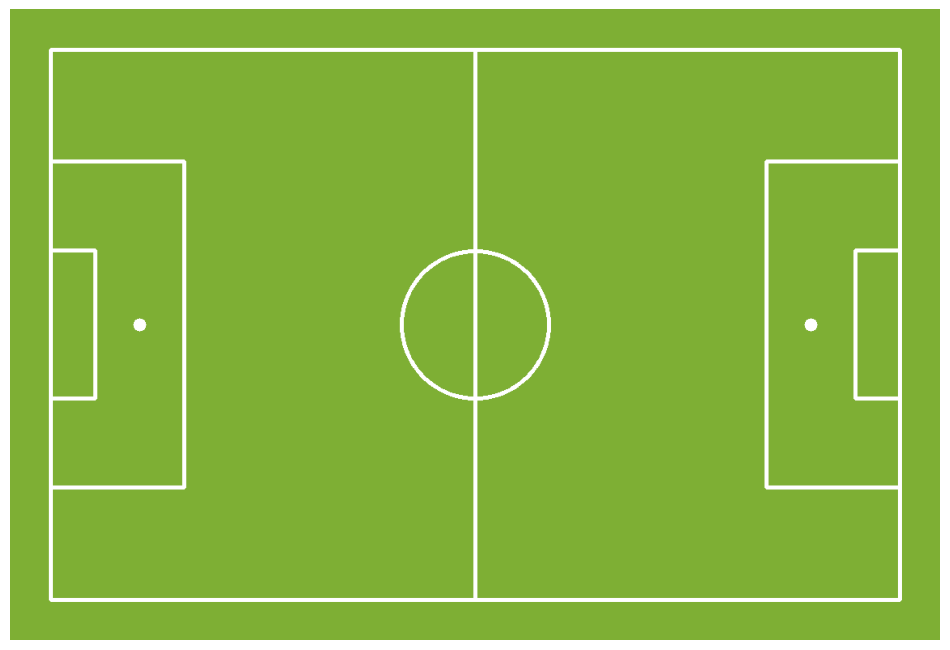

In [7]:
annotated_frame = draw_football_pitch(CONFIG)

sv.plot_image(annotated_frame)

In [8]:
from football_analytics.camera_estimation.view_transformer import ViewTransformer


0: 640x640 1 pitch, 668.4ms
Speed: 1.7ms preprocess, 668.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


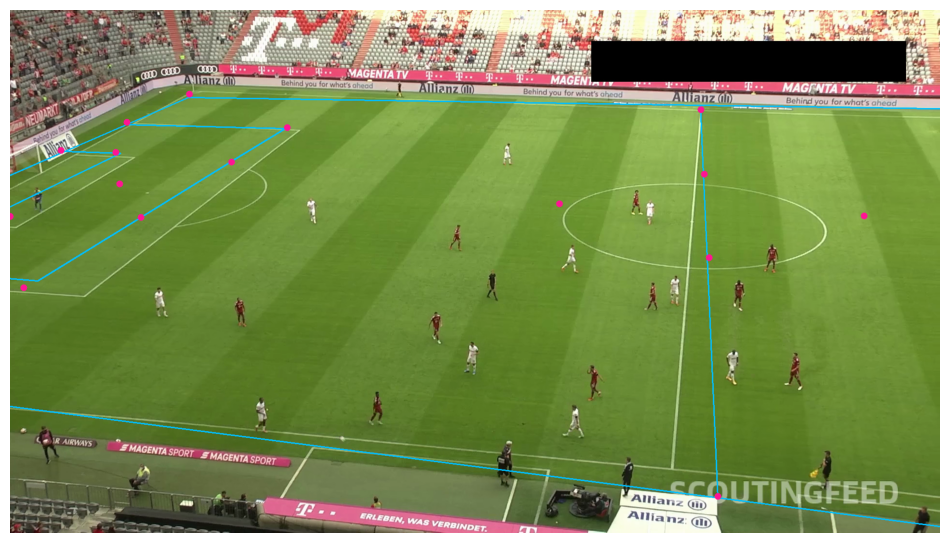

In [9]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex("#FF1493"),
    radius=7
)
edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('00BFFF'),
    thickness=2,
    edges=CONFIG.edges
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
frame = next(frame_generator)
frame = next(frame_generator)
frame = next(frame_generator)

height, width, _ = frame.shape
frame_image_resized = cv2.resize(frame, (640, 640))

result = KEYPOINTS_DETECTION_MODEL.predict(frame_image_resized, conf=0.3)[0]
keypoints = sv.KeyPoints.from_ultralytics(result)
keypoints.xy[0] = keypoints.xy[0] / 640 * np.array([width, height]).T

# remove random keypoints using confidence if needed
filter = keypoints.confidence[0] > 0.5
frame_reference_points = keypoints.xy[0][filter]
frame_reference_keypoints = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = view_transformer.transform_points(pitch_all_points)
frame_all_keypoints = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(annotated_frame, frame_all_keypoints)
annotated_frame = vertex_annotator.annotate(annotated_frame, frame_reference_keypoints)

sv.plot_image(annotated_frame)

### Players part


0: 736x1280 1 goalkeeper, 20 players, 3 referees, 1600.8ms
Speed: 5.4ms preprocess, 1600.8ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 balls, 1485.0ms
Speed: 5.5ms preprocess, 1485.0ms inference, 0.8ms postprocess per image at shape (1, 3, 736, 1280)

0: 640x640 1 pitch, 633.2ms
Speed: 1.5ms preprocess, 633.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


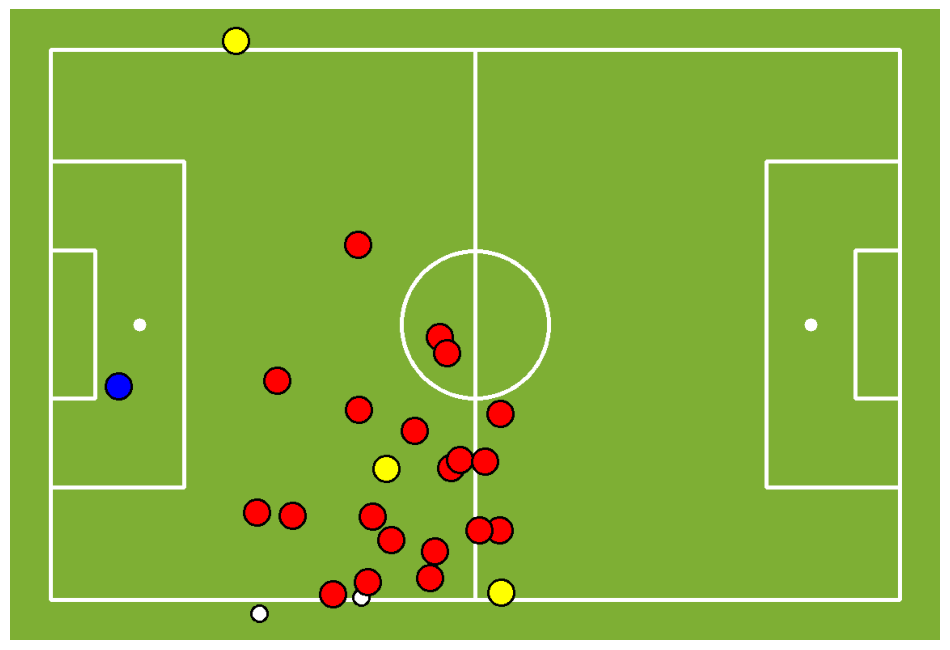

In [10]:
GOALKEEPER_ID = 0
PLAYER_ID = 1
REFEREE_ID = 2

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
frame = next(frame_generator)
frame = next(frame_generator)
frame = next(frame_generator)


result = PLAYER_INFERENCE_MODEL.predict(frame, conf=0.3)[0]
detections = sv.Detections.from_ultralytics(result)

result = BALL_INFERENCE_MODEL.predict(frame, conf=0.1)[0]
ball_detections = sv.Detections.from_ultralytics(result)

ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

players_detections = detections[detections.class_id == PLAYER_ID]
goalkeepers_detections = detections[detections.class_id == GOALKEEPER_ID]
referees_detections = detections[detections.class_id == REFEREE_ID]


result = KEYPOINTS_DETECTION_MODEL.predict(frame_image_resized, conf=0.3)[0]
keypoints = sv.KeyPoints.from_ultralytics(result)
keypoints.xy[0] = keypoints.xy[0] / 640 * np.array([width, height]).T



# remove random keypoints using confidence if needed
filter = keypoints.confidence[0] > 0.5
frame_reference_points = keypoints.xy[0][filter]
frame_reference_keypoints = sv.KeyPoints(xy=frame_reference_points[np.newaxis, ...])
pitch_reference_points = np.array(CONFIG.vertices)[filter]

view_transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = view_transformer.transform_points(frame_ball_xy)

frame_players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = view_transformer.transform_points(frame_players_xy)

frame_goalkeepers_xy = goalkeepers_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_goalkeepers_xy = view_transformer.transform_points(frame_goalkeepers_xy)

frame_referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = view_transformer.transform_points(frame_referees_xy)

pitch = draw_football_pitch(config=CONFIG)

if pitch_ball_xy.size != 0:
    pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_ball_xy,
        main_color=sv.Color.WHITE,
        edge_color=sv.Color.BLACK,
        radius=10,
        pitch=pitch
    )

if pitch_players_xy.size != 0:
    pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_players_xy,
        main_color=sv.Color.RED,
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=pitch
    )

if pitch_goalkeepers_xy.size != 0:
    pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_goalkeepers_xy,
        main_color=sv.Color.BLUE,
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=pitch
    )

if pitch_referees_xy.size != 0:
    pitch = draw_points_on_pitch(
        config=CONFIG,
        xy=pitch_referees_xy,
        main_color=sv.Color.YELLOW,
        edge_color=sv.Color.BLACK,
        radius=16,
        pitch=pitch
    )

sv.plot_image(pitch)